# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #4
**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 6th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators
<br>
**Group Name: Homework3 44 Homework 4**




**Joe Davidson**
<br>
**Anna Davydova**
<br>
**Michael Emmanuel**
<br>
**Dylan Randle**
<br>

In [1]:
import math
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [2]:
# Additional imports
import seaborn as sns
from sklearn.neighbors import KernelDensity
from numpy import sqrt, log, exp
from scipy.special import gamma
from scipy.stats import norm, entropy
from typing import Tuple, List, Dict

# Set plotting style
matplotlib.rcParams.update({'font.size': 18})

## Question 1: Rubber Chickens Bawk Bawk!

In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018fall/homeworks/lotus1.png) |  ![alt](https://am207.github.io/2018fall/homeworks/lotus1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018fall/homeworks/lotus2.png) |  ![alt](https://am207.github.io/2018fall/homeworks/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


1.1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

1.2. Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

1.3. Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
1.4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.

1.5. Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

1.6. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

1.7. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

1.8. Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

In [249]:
# Utility functions
def normalize(a: np.ndarray):
    """Normalize array a so it sums to 1.0"""
    s: float = np.sum(a)
    return (1.0 / s) * a


def integer_ratings(rf: np.ndarray, count: int) -> np.ndarray:
    """
    Given percentage of ratings and the total count, estimate the integer total in each bucket.
    rf is a vector of ratings fractions adding up to 1.0
    count is the total number of ratings across all bins
    returns: rc_int, an array with an integer number of ratings in each bucket
    """
    # Estimate the number of ratings in each bucket without an integer constraint
    rc_flt: np.ndarray = count * rf
    # Initial guess as that each bucket has the nearest integer to the estimate
    rc_int: np.ndarray = np.round(rc_flt)
    # Compute the residuals in each bucket and their total
    resids: np.ndarray = rc_int - rc_flt
    total_resid: int = np.round(np.sum(resids))
    
    # As long as the total residual is positive, adjust rc_int by 
    # finding the category with the largest residual and decrementing it
    while total_resid > 0:
        # Find the index of the largest residual
        idx: int = np.argmax(resids)
        # Decrement this slot
        rc_int[idx] -= 1
        # Update resids and total_resid
        resids = rc_int - rc_flt
        total_resid = np.round(np.sum(resids))
        
    # As long as the total residual is negative, adjust rc_int by 
    # finding the category with the smallest residual and incrementing it
    while total_resid < 0:
        # Find the index of the largest residual
        idx: int = np.argmin(resids)
        # Increment this slot
        rc_int[idx] += 1
        # Update resids and total_resid
        resids = rc_int - rc_flt
        total_resid = np.round(np.sum(resids))
        # As long as the total residual is positive (too large), adjust rc_int by 
    # finding the categore with the largest residual and decrementing it
    while total_resid > 0:
        # Find the index of the largest residual
        idx: int = np.argmax(resids)
        # Decrement this slot
        rc_int[idx] -= 1
        # Update resids and total_resid
        resids = rc_int - rc_flt
        total_resid = np.round(np.sum(resids))
    
    return rc_int

In [250]:
# Dirichlet prior
def dirichlet_normalization(alpha: np.ndarray):
    """Compute the normalization term B(alpha) in the Dirichlet distribution"""    
    # Compute gamma(alpha[i]) for each of the input alphas
    gamma_alpha: np.ndarray = gamma(alpha)
    # The numerator is the product of these terms
    beta_num: float = np.prod(gamma_alpha)
    # The denominator is the gamma function on the sum of the alphas
    beta_den: float = gamma(np.sum(alpha))
    # Return B(alpha)
    return beta_num / beta_den

def dirichlet_prior(alpha: np.ndarray, theta: np.ndarray):
    """
    A dirichlet prior function
    alpha is the vector of weights on each category
    theta is the vector of inputs theta at which f_alpha(theta) is evaluated
    """
    # Data integrity check
    if alpha.shape != theta.shape:
        raise ValueError('alpha and theta must have the same shape.')
    # Compute the powers theta[i]^[alpha[i]-1]
    theta_pow: np.ndarray = np.power(alpha, theta - 1)
    # Get the normalization term B(alpha)
    B: float = dirichlet_normalization(alpha)
    # The evaluated function is the product of the thetas to the powers over the normalizer
    return np.prod(theta_pow) / B

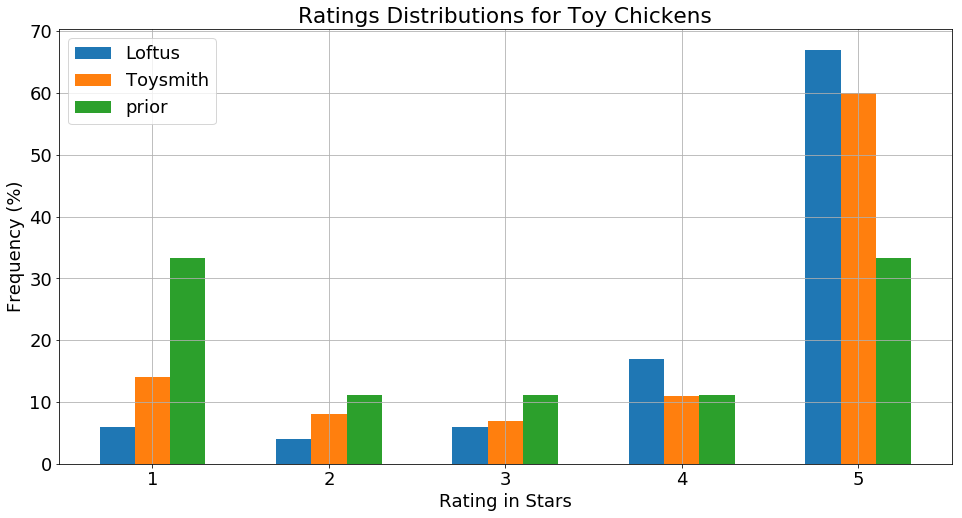

In [251]:
# product names as a tuple
nms: Tuple[str, str] = ('Loftus', 'Toysmith')
nm_1: str = nms[0]
nm_2: str= nms[1]

# Star ratings
ratings: np.ndarray = np.array([1,2,3,4,5])

# Copying the ratings percentages for Loftus and Toysmith from review screenshot as vectors
# Put them in the order 1 star, 2 star, ... 5 star to match specification below
# The [::-1] at the end of the lists reverses the order, because I transcribed
# them in the top to bottom order that was reported on Amazon.

# Loftus
count_1: int = 162
rf_1: np.ndarray = 0.01 * np.array([67, 17, 6, 4, 6][::-1])

# Toysmith
count_2: int = 410
rf_2: np.ndarray = 0.01 * np.array([60, 11, 7, 8, 14][::-1])

# Both rating fractions and counts
rfs: Tuple[np.ndarray, np.ndarray] = (rf_1, rf_2)
counts: Tuple[int, int] = (count_1, count_2)
    
# Normalize both rating fractions if they don't sum up to 1 due to roundoff
for rf in rfs:
    if not np.isclose(np.sum(rf), 1.0):
        rf = normalize(rf)

# Infer the integer number of ratings in each bucket
rc_1: np.ndarray = integer_ratings(rf_1, count_1)
rc_2: np.ndarray = integer_ratings(rf_2, count_2)

# Create a Dirichlet prior 
alpha_prior = normalize(np.array([3.0, 1.0, 1.0, 1.0, 3.0]))

# Plot the ratings distribution for both vendors
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Ratings Distributions for Toy Chickens')
ax.set_xlabel('Rating in Stars')
ax.set_ylabel('Frequency (%)')
# Set up multiple bars
width=0.2
k: int = 3
offsets = np.linspace(-width*(k-1)/2, width*(k-1)/2, num=k)
# Plot bars for both vendors and prior
ax.bar(x=ratings + offsets[0], height=rf_1*100, width=width, label=nm_1)
ax.bar(x=ratings + offsets[1], height=rf_2*100, width=width, label=nm_2)
ax.bar(x=ratings + offsets[2], height=alpha_prior*100, width=width, label='prior')
ax.legend()
ax.grid()

**1.1** In the code above I imported the ratings data for both vendors, Loftus World and Toysmith.  I estimated integer numbers of ratings in each category consistent with the reported percentages (which Amazon rounds to the nearest percent) and the total number of ratings.  I created utility functions to normalize an array and estimate integer counts in each ratings bucket.

I also wrote utility functions that evaluate a Dirichlet fuction given $\alpha$ and $\theta$, with an intermediate step of computing the normalization function $B(\alpha)$.  We are asked to choose an appropriate Dirichlet prior given the information that ratings are polarized between strong feelings at either end of the spectrum online.  I don't think there's any one right answer to this problem.  I wanted a mostly uninformative prior (i.e. relatively high entropy), but that reflected the given information about polarization.  The maximum entropy and least informative prior would have been a weight of 0.2 on each category.  I chose to assign weights of 1/3 on each of the two extremes (1 star and 5 star) and 1/9 on the the three remaining middle ratings.  I plotted this prior against both products as a sanity check and it looks reasonable to me. Please not that our our prior's alpha = [3, 1, 1, 1, 3] 

**1.2** We can compute the posterior probability by multiplying the prior by the PDF.  I am going to write 
$$\text{Dir}(\theta | \alpha) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1} $$ 
to refer to the Dirichlet function because I find the above notation slightly confusing.  Suppose we draw one data point $x$ and it falls into category $r$.  The multinomial PDF above depends on $n$, $x_i$ and $\theta_i$ for $i$ between 1 and 5.  When we draw just 1 point, $n=1$, $x_i = 0$ for $i \ne r$ and $x_r = 1$.  All the terms $\theta_i^{x_i}$ for $i \ne r$ drop out because they have zero exponents, and the ratio of factorials up front reduces to $1!$ over a product of $1!$ and $0!$ all of which are 1.  So the whole thing boils down to $\theta_r$.  We can now evaluate the posterior in light of one data point:

$$p(\theta | \alpha, x_i = r) \propto \prod_{i=1}^k \theta_i^{\alpha_i - 1} \cdot  \theta_r = \prod_{i=1}^k \theta_i^{\alpha^{post}_i - 1}$$

Here, $\alpha^{post}$ is the posterior update to $\alpha$, which was the same as the starting $\alpha$, except we add 1 in slot $r$ that got a hit on this trial.  This is a completely intuitive result: because the Dirichlet prior is a conjugate prior, the effect of observing one new data point is increase $\alpha_r$ in that slot by 1.  The form of the posterior remains the same.  To have a clean looking answer, after n trials with a total number of outcomes $x_1$, ... $x_5$ falling into categories 1 through 5 respectively, the updated $\alpha$ vector and posterior are shown below:

$$\alpha^{post} = (\alpha_1 + x_1, ..., \alpha_k + x_k)$$
$$p(\theta | \alpha, x_i = r) = \text{Dir}(\theta | \alpha^{post})$$

This is why we like working with conjugate priors-- they make all the math come out really cleanly!  The above gives us an expression for the posterior of $\theta$.  The question asked us for a posterior PDF.  That is going to be the integral of the pdf given $\theta$, integerated over the posterior probability of $\theta$:

$$f_{\mathbf{X}\vert  \Theta, {x_i}} (\mathbf{x}) = 
\int_{\theta} f_{\mathbf{X}\vert \Theta} (\mathbf{x}) p(\theta \vert {x_i}) d\theta =
\frac{n!}{x_1! \ldots x_k!} \int_{\theta} \theta_1^{x_1} \ldots \theta_k^{x_k} \text{Dir}(\theta | \alpha^{post}) d\theta$$

While this looks like a mouthful, it's not that bad.  The terms involving $n!$ and $x_i!$ are constants that pull out.  The product of $\theta$ to the powers of the number of observed hits are now just weighted by the posterior probability of each possible assignment of $\theta$.  I don't know if this has a closed form analytical solution, but it's easy to sample from the posteriors for both $\theta$ and $\mathbf{x}$.

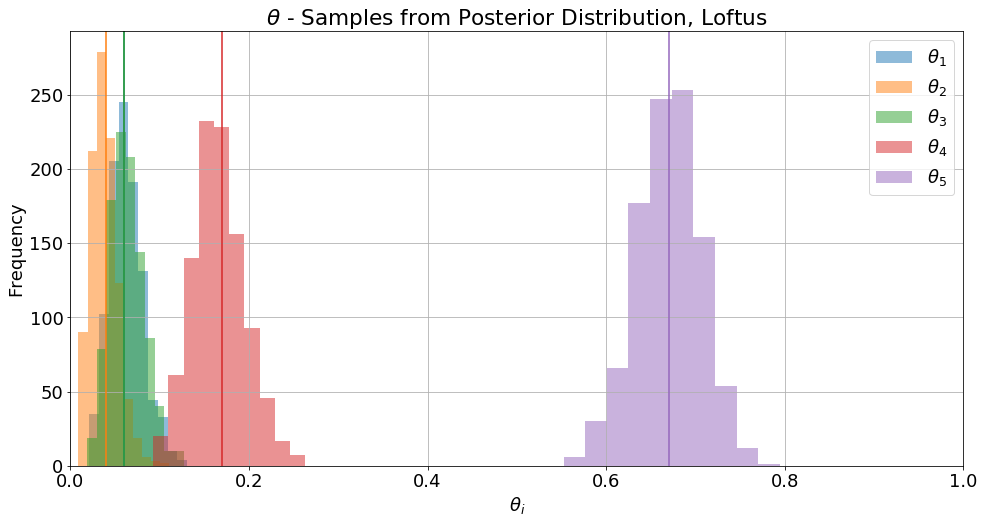

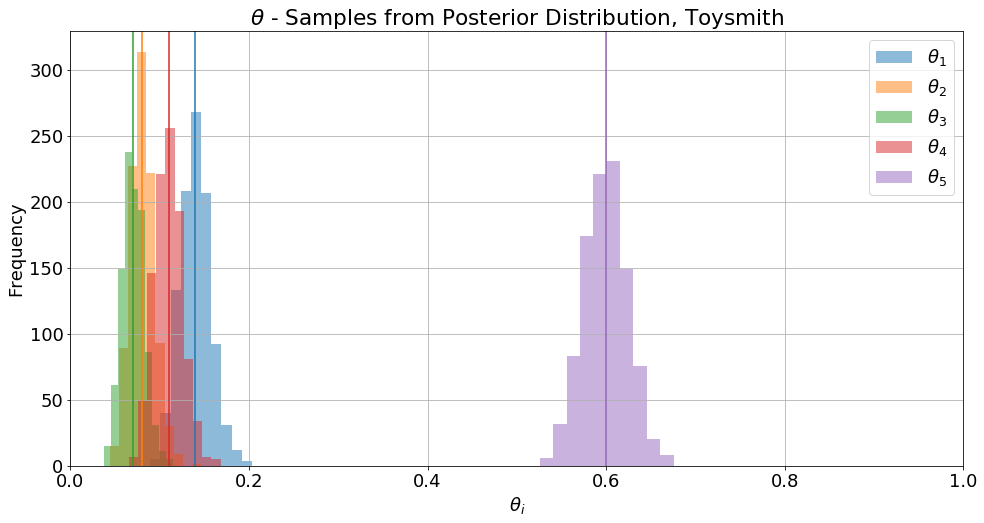

In [252]:
# 1.3. Sample 1,000 values of θ from the posterior distribution.
# Compute alpha_post_1 and alpha_post_2, the posterior alpha for each vendor
alpha_post_1 = alpha_prior + rc_1
alpha_post_2 = alpha_prior + rc_2

# Sample values of theta for each vendor from the Dirichlet distribution with these alpha values
sample_count: int = 1000
theta_post_1 = np.random.dirichlet(alpha=alpha_post_1, size=sample_count)
theta_post_2 = np.random.dirichlet(alpha=alpha_post_2, size=sample_count)
theta_posts = (theta_post_1, theta_post_2)

# Plot the thetas for both bendors
for i, theta_post in enumerate(theta_posts):
    fig, ax = plt.subplots()
    fig.set_size_inches([16, 8])
    # Get name and rating frequency for this vendor
    nm = nms[i]
    rf = rfs[i]
    # Plot histogram of theta drawn from posterior distribution and empirical frequency
    ax.set_title(r'$\theta$ - Samples from Posterior Distribution, ' + f'{nm}')
    ax.set_xlabel(r'$\theta_i$')
    ax.set_ylabel('Frequency')
    ax.set_xlim([0,1])
    for i in range(5):
        # Historigram of theta
        hist = ax.hist(theta_post[:,i], label= r'$\theta' + f'_{i+1}$', alpha=0.5)
        # Vertical line at empirical frequency
        last_color = list(x for x in hist[2][0].get_facecolor())
        last_color[3] = 1.0
        ax.axvline(x=rf[i], color=last_color)
    ax.legend()
    ax.grid()

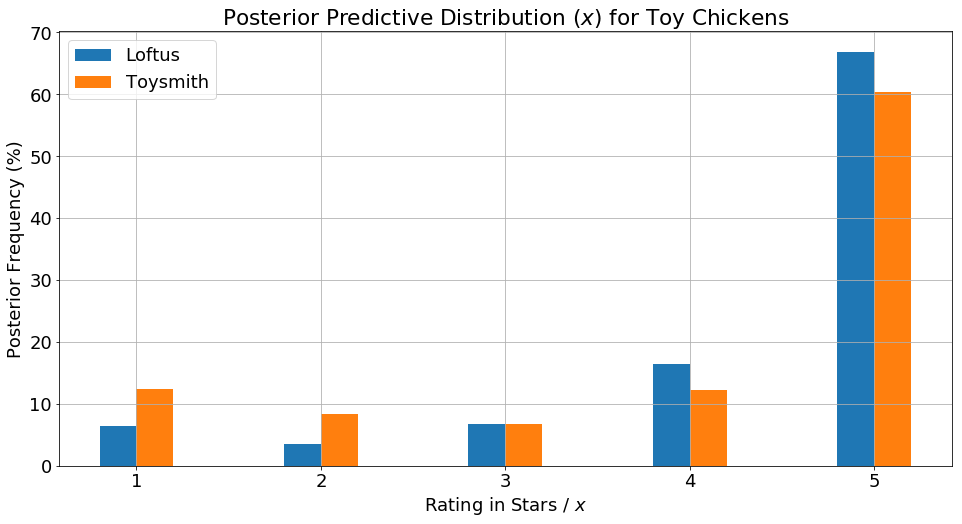

In [253]:
# *************************************************************************************************
# 1.4. Sample 1,000 values of x from the posterior predictive distribution.
# Initialize both samples to zeroes
x_pred_1 = np.zeros(sample_count)
x_pred_2 = np.zeros(sample_count)
# For each trial, first sample theta
for i in range(sample_count):
    theta_1 = theta_post_1[i]
    theta_2 = theta_post_2[i]
    # Now sample x from the multinomial distribution given this theta
    # Since we're just choosing 1 sample at a time, this reduces to a random choice with weights
    x_pred_1[i] = np.random.choice(ratings, size=1, p=theta_1)
    x_pred_2[i] = np.random.choice(ratings, size=1, p=theta_2)

# Determine the posterior ratings frequency
rf_pred_1 = np.unique(x_pred_1, return_counts=True)[1] / sample_count
rf_pred_2 = np.unique(x_pred_2, return_counts=True)[1] / sample_count
    
# Plot the posterior ratings distribution for both vendors
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Posterior Predictive Distribution ($x$) for Toy Chickens')
ax.set_xlabel('Rating in Stars / $x$')
ax.set_ylabel('Posterior Frequency (%)')
# Set up multiple bars
width=0.2
k: int = 2
offsets = np.linspace(-width*(k-1)/2, width*(k-1)/2, num=k)
# Plot bars for both vendors and prior
ax.bar(x= ratings + offsets[0], height=rf_pred_1*100, width=width, label=nm_1)
ax.bar(x= ratings + offsets[1], height=rf_pred_2*100, width=width, label=nm_2)
ax.legend()
ax.grid()

**1.5** There is much more information in a vector of ratings frequencies for each category (1 through 5 stars) than there is in the mean rating.  The mean is an excellent summary when evaluating an additive quantity, for example, if you're trying to predict the return on a financial investment that will be part of a portfolio whose total return is the weighted average return of its constituents.

The first problem with the mean in comparing products is that it's putting a lot of weight on outliers at each end of the ratings scale.  Consider a toy world where there are two kinds of people, whom I'll label "loud" and "soft".  The "loud" people rate products either 5 or 1 star depending on whether they liked them or not.  The "soft" people rate most products 3-4 stars, reserving 5 star ratings for excellent products and 1-2 stars for really poor one.  Comparing products based on the mean gives much more weight to the opinions of the loud people vs. the soft people.

Running with the idea in the hint for a moment, consider two products A and B.  Prouct A has 80% 5 star ratings and 20% 1 star for a mean of 4.2.  Product B has 80% 4 star and 20% 5 star for the same mean of 4.2.  It's a good bet that more people prefer product A to B, but the means are equal.

My own approach in comparing products based on ratings distribution is to come up with some kind of a utility function for various ratings, which varies quite a lot depending on the product I'm buying.  Sometimes, I'm risk averse, and I put a high weighting on avoiding low ratings.  This would be a good description of my approach when buying e.g. tires.  As the Michelin slogan says, you've got a lot riding on your tires.  If even relatively few people give a tire a one star review because they had blow-outs, I'm going to avoid it like the plague for safety.  On the other hand, sometimes I'm exploring to find a new product that I can buy again if I like it.  I experimented with different brands of coffee beans before discovering one I really liked a lot.  In that case, when exploring new ones to try I put the most weight on people who liked the product a lot.

Ran 1000 head to head trials comparing vendors based on mean theta in posterior distribution.
Vendor 1 Loftus     wins: 338
Vendor 2 Toysmith   wins: 224
Ties                    : 438
Best vendor: Loftus


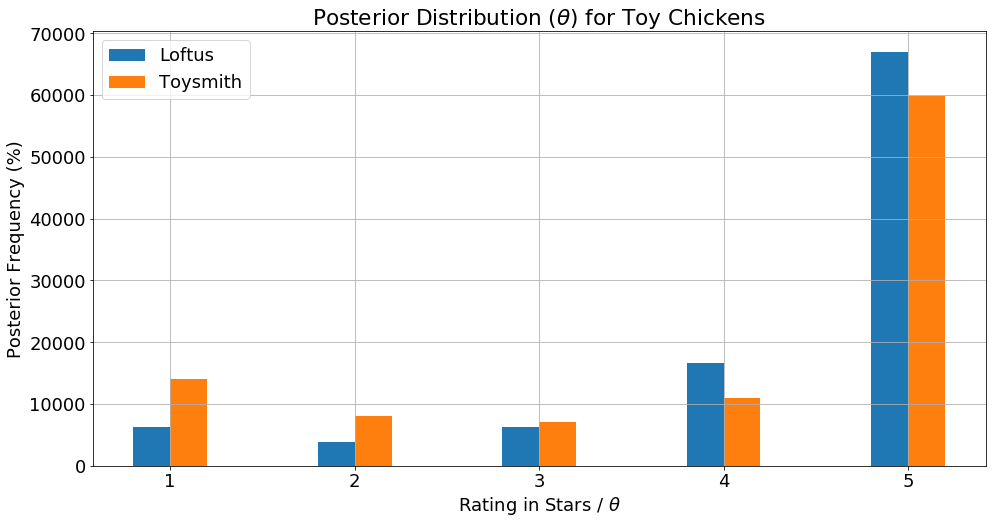

In [254]:
# Determine frequency of theta weightings for both products
rf_theta_1 = np.sum(theta_post_1, axis=0)
rf_theta_2 = np.sum(theta_post_2, axis=0)
# Plot the posterior ratings distribution for both vendors
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Posterior Distribution ($\\theta$) for Toy Chickens')
ax.set_xlabel('Rating in Stars / $\\theta$')
ax.set_ylabel('Posterior Frequency (%)')
# Set up multiple bars
width=0.2
k: int = 2
offsets = np.linspace(-width*(k-1)/2, width*(k-1)/2, num=k)
# Plot bars for both vendors and prior
ax.bar(x= ratings + offsets[0], height=rf_theta_1*100, width=width, label=nm_1)
ax.bar(x= ratings + offsets[1], height=rf_theta_2*100, width=width, label=nm_2)
ax.legend()
ax.grid()

# In each sample draw, compare products in theta space by the mean of theta
theta_trial_1 = np.array(\
        [np.random.choice(ratings, size=1, p=theta_post_1[i]) for i in range(sample_count)])
theta_trial_2 = np.array(\
        [np.random.choice(ratings, size=1, p=theta_post_2[i]) for i in range(sample_count)])
# Head-to-head wins by each vendor
wins_theta_1 = np.sum(theta_trial_1 > theta_trial_2)
wins_theta_2 = np.sum(theta_trial_1 < theta_trial_2)
ties_theta = np.sum(theta_trial_1 == theta_trial_2)
best_nm_theta = nm_1 if wins_theta_1 > wins_theta_2 else nm_2
# Print results
print(f'Ran {sample_count} head to head trials comparing vendors based on mean theta in posterior distribution.')
print(f'Vendor 1 {nm_1:10} wins: {wins_theta_1}')
print(f'Vendor 2 {nm_2:10} wins: {wins_theta_2}')
print(f'Ties                    : {ties_theta}')
print(f'Best vendor: {best_nm_theta}')

**1.6** The first approach I tried above was to simulate 1,000 head to head matchups between vendors 1 and 2.  In each of the matchups, I first drew $\theta$ from the posterior distribution for each vendor.  Then I randomly sampled one of the $\theta$ using the probability weights.  This simulation produced 323 wins for Loftus, 230 wins for Toysmith, and 230 ties.  By this metric, Loftus is superior.

A second, simpler approach would be to just look at the vector of parameter estimates and observe that Loftus essentially strictly dominates Toysmith.  If I count a "good" rating as 4 or 5 stars, Loftus is more likely to achieve both of those good ratings.  On a neutral rating, they're close to tied.  And on a bad rating of 1-2 stars, Toysmith is more likely to get one.

By comparing $\theta$, I conclude that toy chickens by Loftus have higher ratings on Amazon.

In [255]:
# 1.7. Using the samples from your posterior predictive distribution, determine which rubber chicken product is 
# superior. Justify your conclusion with sample statistics.

# Head-to-head wins by each vendor
wins_pred_1 = np.sum(x_pred_1 > x_pred_2)
wins_pred_2 = np.sum(x_pred_2 > x_pred_1)
ties_pred = np.sum(x_pred_1 == x_pred_2)
best_nm_theta = nm_1 if wins_theta_1 > wins_theta_2 else nm_2
# Print results
print(f'Ran {sample_count} head to head trials comparing vendors based on draws from posterior predictive distribution.')
print(f'Vendor 1 {nm_1:10} wins: {wins_pred_1}')
print(f'Vendor 2 {nm_2:10} wins: {wins_pred_2}')
print(f'Ties                    : {ties_theta}')
print(f'Best vendor: {best_nm_theta}')

Ran 1000 head to head trials comparing vendors based on draws from posterior predictive distribution.
Vendor 1 Loftus     wins: 339
Vendor 2 Toysmith   wins: 242
Ties                    : 438
Best vendor: Loftus


**1.7** The commentary here is analogous to question 1.6.  I simulated 1,000 head to head matchups between the two vendors.  This was even simpler than in the case of theta, because the posterior predictive samples were already star ratings.  I simply compared the ratings for the two products and scored each interaction as a win or draw accordingly.  The results were essentially identical to the comparison based on $\theta$, because in this case $\theta$ maps directly to sampling probabilities.  Loftus had 327 wins vs. 225 for Toysmith, with 447 draws.  So on this metric too I conclude that Loftus has higher ratings on Amazon.

**1.8** Finally, which rubber chicken product is superior?

I think this is a bit of a trick question! In my opinion, this analysis cannot possibly hope to answer the question of which chicken is better, because its scope is limited to comparing the Amazon reviews of the two products.  Amazon reviews can be informative, but they are also subject to a number of serious problems including fraud and inconsistent standards applied by different reviewers.

With that disclaimer out of the way, I will answer this question: which rubber chicken product has "better" reviews on Amazon?  Here too there are many ways we could compare two ratings vectors.  Fortunately we don't need to worry about that here, because the reviews of the Loftus product "strictly dominate" the Toysmith product.  Loftus is more likely to get either kind of a "good review" (4 or 5 stars), and less likely to get a bad review (1 or 2 stars).  I conclude the Loftus rubber chicken is rated higher on Amazon.

## Question 2: He Who is Not Courageous Enough to Take Risks Will Accomplish Nothing In Life

**No Coding required**

Consider a setting where the feature and label space are $\mathcal{X} = \mathcal{Y} = [0, 1]$.    In this exercise we will consider both the square loss and the absolute loss, namely:

$$ \mathbb{l}_{sq}(y_1, y_2) = (y_1 - y_2)^2 $$
$$ \mathbb{l}_{abs}(y_1, y_2) = \left | y_1 - y_2 \right | $$


Let (X, Y) be random, with the following with joint probability density $p_{XY}(x, y) = 2y$, where $x, y \ \in \  [0, 1]$.  We define **statistical risk** as follows:

**Definition (Statistical Risk)** For a prediction rule $f$ and a joint distribution of features and labels $P_{XY}$ the statistical risk $\mathcal{R}(f)$ of $f$ is defined as 

$$\mathcal{R}(f) \equiv \mathbb{E}_{XY}\left[\mathbb{l}(f(X),Y)\ |\ f \right]$$,

where $(X, Y) \sim P_{XY}$.  The conditional statement ensures the definition is sensible even if $f$ is a random quantity.


2.1. Show that in this case $X$ and $Y$ are independent, meaning the feature $X$ carries no information about Y.

2.2. What is the risk of prediction rule $f(x) = \frac{1}{2}$ according to the two loss functions?

2.3. What is the risk of the prediction rule $f^*(x) = \frac{1}{\sqrt{2}}$ according to the two loss functions?

2.4. Show that $f^*$ has actually the smallest absolute loss risk among all prediction rules.

**Hint (for 2.3):**

    * In general the Bayes predictor according to the absolute value loss is the median of the conditional distribution of $Y$ given $X = x$.

**2.1** Our friends at Wikipedia remind us that two variables X and Y are independent if their joint probability distribution $P_{XY}(x, y)$ can be factored into the product of the two distributions $p_X(x)$ and $p_Y(y)$.
https://en.wikipedia.org/wiki/Independence_(probability_theory)

We are given the joint distribution $p_{XY}(x, y)$, and because it is analytically tractable, we can directly evaluate the marginal distributions $p_X(x)$ and $p_Y(y)$ by integration:

$$p_X(x) = \int_{y=0}^1 p_{XY}(x, y) dy = \int_{y=0}^1 2y dy = \left.y^2 \right]_0^1 = 1$$
$$p_Y(y) = \int_{x=0}^1 p_{XY}(x, y) dx = \int_{x=0}^1 2y dx = 2y \int_{x=0}^1 dx = 2y$$

We can now immediately see that the joint distribution does indeed factor into the product of the two marginals, i.e. it's a separable distribution:

$$p_X(x) \cdot p_Y(y) = 1 \cdot 2y = p_{XY}(x, y)$$

**2.2** Start with squared loss function:

$$\mathcal{R}(f) = \mathbb{E}_{XY}\left[\mathbb{l_{sq}}({1/2},Y) \right] =
\mathbb{E}_{XY}\left[({1/2}-Y)^2 \right] = \mathbb{E}_{XY}\left[({1/4}-Y+Y^2 \right]$$
Taking these terms one at a time, $\mathbb{E}_{XY}\left[{1/4}\right] = 1/4$ (expectation of a constant).

$$\mathbb{E}_{XY}\left[Y\right] = \mathbb{E}_{Y}\left[Y\right] =
\int_{y=0}^1 y p(y) dy = \int_{y=0}^1 2y^2 dy = \left.\frac{2}{3}y^3\right]_0^1 = \frac{2}{3}$$
We dropped the $X$ from the expectation $\mathbb{E}_{XY}$ because $X$ does not appear inside.

$$\mathbb{E}_{XY}\left[Y^2\right] = \mathbb{E}_{Y^2}\left[Y\right] =
\int_{y=0}^1 y^2 p(y) dy = \int_{y=0}^1 2y^3 dy = \left.\frac{1}{2}y^3\right]_0^1 = \frac{1}{2}$$

$$\mathcal{R}(f) = \frac{1}{4} - \frac{2}{3} + \frac{1}{2} = \frac{1}{12} 
\text{  with squared loss } \mathbb{l_{sq}}$$

Next take the absolute value loss function:

$$\mathcal{R}(f) = \mathbb{E}_{XY}\left[\mathbb{l_{abs}}({1/2},Y) \right] =
\mathbb{E}_{XY}\left[\left|1/2-Y\right| \right] = \mathbb{E}_{Y}\left[\left|1/2-Y\right| \right]$$
We can take the expectation of the absolute value by splitting the integral at $y=1/2$:
$$\mathbb{E}_{Y}\left[\left|1/2-Y\right| \right] = 
\int_{y=0}^{1/2} (\frac{1}{2} - y) p_Y(y) dy + \int_{y=1/2}^{1} (y - \frac{1}{2}) p_Y(y) dy$$
Taking each of these integrals separately:
$$\int_{y=0}^{1/2} (\frac{1}{2} - y) 2y dy =\int_{y=0}^{1/2} (y - 2y^2) dy = 
\left.\frac{1}{2}y^2-\frac{2}{3}y^3\right]_0^{1/2} = \frac{1}{8} - \frac{1}{12} = \frac{1}{24}$$

$$\int_{y=1/2}^{1} (y - \frac{1}{2}) 2y dy =\int_{y=1/2}^{1} (2y^2 - y) dy = 
\left.\frac{2}{3}y^3 - \frac{1}{2}y^2\right]_{1/2}^{1} = \frac{1}{6} - -\frac{1}{24} = \frac{5}{24}$$

$$\mathcal{R}(f) = \frac{1}{4} \text{  with abolute value loss } \mathbb{l_{abs}}$$

**2.3** The calculation for the squared risk with $f^*(x) = \sqrt{2}/2$ is
$$\mathcal{R}(f) = \mathbb{E}_{XY}\left[\left(\frac{\sqrt{2}}{2}-Y \right)^2 \right] = 
\mathbb{E}_{Y}\left[\frac{1}{2}-\sqrt{2}Y+Y^2 \right]$$

Previously we saw that $\mathbb{E}_{Y}\left[Y\right] = 2/3$ and $\mathbb{E}_{Y^2}\left[Y\right] = 1/2$, so 

$$\mathcal{R}(f^*) = 1 - \frac{2\sqrt{2}}{3} 
\text{  with squared loss } \mathbb{l_{sq}}$$

We use the same technique to compute the risk with the absolute value loss: split the integral of $y$ at $\sqrt{2}/2$.

$$\mathcal{R}(f) = 
\int_{y=0}^{\sqrt{2}/2} \left(\frac{\sqrt{2}}{2} - y\right) 2y dy + 
\int_{y=\sqrt{2}/2}^{1} \left(y - \frac{\sqrt{2}}{2}\right) 2y dy = 
\int_{y=0}^{\sqrt{2}/2} \left(\sqrt{2}y - 2y^2\right) dy + 
\int_{y=\sqrt{2}/2}^{1} \left(2y^2 - \sqrt{2}y\right) dy$$

Taking these two integrals in turn,
$$\int_{y=0}^{\sqrt{2}/2} \left(\sqrt{2}y - 2y^2\right) dy = 
\left.\frac{\sqrt{2}}{2}y^2 - \frac{2}{3}y^3\right]_0^{\sqrt{2}/2} = 
\frac{\sqrt{2}}{4} - \frac{\sqrt{2}}{6} = \frac{\sqrt{2}}{12}$$
$$\int_{y=\sqrt{2}/2}^{1} \left(2y^2 - \sqrt{2}y\right) dy =
\left.\frac{2}{3}y^3 - \frac{\sqrt{2}}{2}y^2\right]_{\sqrt{2}/2}^1 = 
\left(\frac{2}{3} - \frac{\sqrt{2}}{2}\right) -\left(\frac{\sqrt{2}}{6} - \frac{\sqrt{2}}{4}\right) = 
\frac{2}{3} - \frac{5\sqrt{2}}{12}$$

Adding these two terms up,
$$\mathcal{R}(f^*) = \frac{2}{3} - \frac{\sqrt{2}}{3} 
\text{  with abolute value loss } \mathbb{l_{abs}}$$

Just for fun, I present below a quick numerical verification that both of these answers are correct.

In [256]:
def arange_inc(start, stop, step):
    """Just like numpy arange function, but the endpoint stop is INCLUDED."""
    return np.arange(start, stop + step, step)

def p(y: float) -> float:
    """Marginal distribution p(y)"""
    return 2*y

def f1(y: float) -> float:
    return 0.5

def f2(y: float) -> float:
    return sqrt(2) / 2
# Compute risk via a numerical integral
dy: float = 0.0001
grid_y = arange_inc(0.0, 1.0, dy)
grid_p = p(grid_y) * dy
grid_f1 = f1(grid_y)
grid_f2 = f2(grid_y)

# Risk on the grid
loss_f1_sqr = np.power((grid_f1 - grid_y), 2)
loss_f1_abs = np.abs(grid_f1 - grid_y)
# Loss is the expected value of risk
risk_f1_sqr = np.sum(loss_f1_sqr * grid_p)
risk_f1_abs = np.sum(loss_f1_abs * grid_p)
# Analytical answers
risk_f1_sqr_an = 1/12
risk_f1_abs_an = 1/4
# Errors
error_f1_sqr = abs(risk_f1_sqr_an - risk_f1_sqr)
error_f1_abs = abs(risk_f1_abs_an - risk_f1_abs)
# Report results
print(f'Risk of function f(x):')
print(f'Squared  loss function: {risk_f1_sqr:0.6f}, analytical answer {risk_f1_sqr_an:0.6f}, error {error_f1_sqr:0.6f}')
print(f'Absolute loss function: {risk_f1_abs:0.6f}, analytical answer {risk_f1_abs_an:0.6f}, error {error_f1_abs:0.6f}')


# Risk on the grid
loss_f2_sqr = np.power((grid_f2 - grid_y), 2)
loss_f2_abs = np.abs(grid_f2 - grid_y)
# Loss is the expected value of risk
risk_f2_sqr = np.sum(loss_f2_sqr * grid_p)
risk_f2_abs = np.sum(loss_f2_abs * grid_p)
# Analytical answers
risk_f2_sqr_an = 1 - 2*sqrt(2)/3
risk_f2_abs_an = 2/3 - sqrt(2) / 3
# Errors
error_f2_sqr = abs(risk_f2_sqr_an - risk_f2_sqr)
error_f2_abs = abs(risk_f2_abs_an - risk_f2_abs)
# Report results
print(f'\nRisk of function f*(x):')
print(f'Squared  loss function: {risk_f2_sqr:0.6f}, analytical answer {risk_f2_sqr_an:0.6f}, error {error_f2_sqr:0.6f}')
print(f'Absolute loss function: {risk_f2_abs:0.6f}, analytical answer {risk_f2_abs_an:0.6f}, error {error_f2_abs:0.6f}')

Risk of function f(x):
Squared  loss function: 0.083358, analytical answer 0.083333, error 0.000025
Absolute loss function: 0.250050, analytical answer 0.250000, error 0.000050

Risk of function f*(x):
Squared  loss function: 0.057200, analytical answer 0.057191, error 0.000009
Absolute loss function: 0.195291, analytical answer 0.195262, error 0.000029


**2.4** Thanks to the friendly hint, we are reminded that $f^*(x)$ will be the median of the conditional distribution $p_Y(y | x)$.  Earlier we showed that $X$ and $Y$ were independent, so the conditional distribution is just the marginal distribution $p_Y(y) = 2y$.  So it is sufficient to show that the median of this function is $\sqrt{2}/2$.  This is easy.  The property of the median $m$ is that the area with $y\le m$ is equal to the area with $m <= y$, i.e. they are both $1/2$.

$$\int_{y=0}^{\sqrt{2}/2}p_Y(y) dy = \int_{y=0}^{\sqrt{2}/2}2y dy = \left.y^2\right]_0^{\sqrt{2}/2} = 
\frac{1}{2} - 0 = \frac{1}{2}$$

So $f^*(x) = \sqrt{2}/2$ is indeed the median of $p_Y(y)$ as required.

<div class="answer-separator">
------------------------
</div>

## Question 3: Maxwell's Demon Has a Wonderful Way of showing us What Really Matters

**Some Coding required**

3.1. Find the entropy of the exponential probability density on support (0, $\infty$) with mean $\lambda$.

3.2. Show that the exponential distribution $p^*$ is the maximum entropy distribution on support (0, $\infty$)  with specified mean $\lambda$. That is to say prove that for any continuous probability density function $p(x)$ on (0, $\infty$) with mean $\lambda$ then the entropy h(p) <= h($p^*$) with equality if and only if p is also the exponential with mean $\lambda$


We're familiar with the CLT as a way of approximating the sum of IID random variables with an appropriate Normal distribution.  Let's investigate this relationship by using the KL-Divergence.  Given n identically distributed Bernoulli variables $Y_i \sim Bern(p)$, then their sum approaches a Normal distribution.

3.3. Visualize this relationship by drawing n = 10,000 samples from a Bernoulli with p = 0.02.  These samples determine a random variable and thus a probability distribution (which in the last homework we called the empirical distribution of the data).  Visualize this probability distribution by plotting a normed histogram of the samples.  On your plot overlay the appropriately fitted Gaussian distribution.  Make sure to appropriately title and label your plot.

3.4. From visual inspection are the two distributions close to each other?

3.5. Formalize your answer to 3.3 and 3.4 by writing a program to compute the K-L divergence between the two distributions (the sum of 10000 sampled Bernoullis and the appropriate Gaussian).  What is the value of the KL divergence.

3.6. Let's visualize the convergence of the sum of bernoulli RVs to a Gaussian as fortold by the CLT by repeating the process from 3.5 for various values of n.  We'll set our selection of sample sizes to the following: [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 50000, 100000].  Setting n to each of the specified sample sizes repeat the following procedure 10 times:

* Draw n bernoulli samples using the Bernoulli parameter from 3.3 (p=0.02).
* Calculate the Kullback-Leibler divergence between the random variable defined by the sum of Bernoullis samples and the appropriately fitted gaussian. 

For each sample size you should have 10 KL divergences. Construct a log scale (in both axes) plot of the Kullback-Leibler divergence and and the 3-$\sigma$ envelope against the sample size.  What can you convergence of the distributions in question?  What does this mean for the CLT?


**3.1** The exponential distribution is defined by $f(x|\lambda) = \lambda x^{-\lambda x}$ on the interval $(0, \infty)$ where it is supported.  Please note that the mean of this distribution is $\beta = 1 / \lambda$.  This is NOT the notation that was used in the problem, but I'm going to stick to the "standard" notation and express my answer at the end in terms of the mean.

The definition of the differential entropy of a continuous pdf is $H(p) = \int p(x) \log(p(x)) dx$.
Note that $\log(f(x) = \log(\lambda) - \lambda x$

$$H(f(x | \lambda) = -\int_{x=0}^\infty f(x) log(f(x)) dx = 
-\int_{x=0}^\infty \lambda e^{-\lambda x}\left( log \lambda - \lambda x\right) dx$$

Note that $\log \lambda$ is a constant with respect to x, so it factors out of the integral of the pdf which is just 1. So
$$H(f(x | \lambda) = -\log \lambda + \int_{x=0}^\infty (\lambda x) e^{-\lambda x} (\lambda dx)$$
Here I've grouped the terms in $\lambda^2 xe^{-\lambda x} dx$ to make it clear that we can apply the substitution $u=\lambda x$, $du = \lambda dx$.
$$H(f(x | \lambda) = -\log \lambda + \int_{u=0}^\infty u e^{-u} du = 1 - \log \lambda$$
In the last step, note that the well known integral $\int_{u=0}^\infty u e^{-u} du = 1$.  This is the gamma function at $s=2$ corresponding to $1!$.  It can be done via integration by parts as $d/dx(xe^{-x}) = -xe^{-x} - e^{-x}$

Now I will express the entropy in terms of the mean $\beta$.  
$$H(f(x))= 1 + \log \beta$$

**3.2** Start with the relationship between differential entropy and the KL divergence that was presented in class on page 16 of lecture notes 6.  That tells us that 
$$H(p, q) = -\mathbf{E}_p[\log(q)]$$
$$\mathbf{D}_{KL}(p, q) = H(p, q) - H(p)$$ 
where $p$ and $q$ are arbitrary distributions.  Rearrange this to solve for $H(p)$ in terms of $H(p, q)$ and the divergence:
$$H(p) = H(p, q) - \mathbf{D}_{KL}(p, q)$$
We also learned that the KL divergence is non-negative (the proof using Jensen's inequality is a standard result and was presented on p. 32 of lecture notes 6).  The idea of the proof is to let $p(x)$ be any distribution with mean $1 / \lambda$. We will then take its differential entropy to $q(x)$, the exponential distribution with decay rate $\lambda$ and mean $1 / \lambda$, and show that the entropy of $H(p) \le H(q)$.

First, because the KL divergence is non-negative, we have right away that $H(p) \le H(p, q)$.
We also have two constraints on $q(x)$.  First, it integrates to 1 because it's a probability distribution.  Second, it's assumed to have mean $1 / \lambda$, so $\int f(x) dx = 1 / \lambda$.  Now evaluate the differential entropy $H(p, q)$:

$$H(p, q) = -\int_{x=0}^\infty p(x) \log q(x) dx = -\int_{x=0}^\infty p(x) (log \lambda - \lambda x) dx = 
-\log \lambda \int_{x=0}^\infty p(x) dx + \lambda \int_{x=0}^\infty x p(x) dx $$

Now we use our two constraints.  The integral of the pdf is just 1, and the first moment is assumed to be $1 / \lambda$.  We conclude that

$$H(p, q) = -\log \lambda + \lambda \cdot (1 / \lambda) = 1 - \log \lambda = H(q)$$

We have thus proven that $H(p) \le H(q)$ as required.

#### 3.3

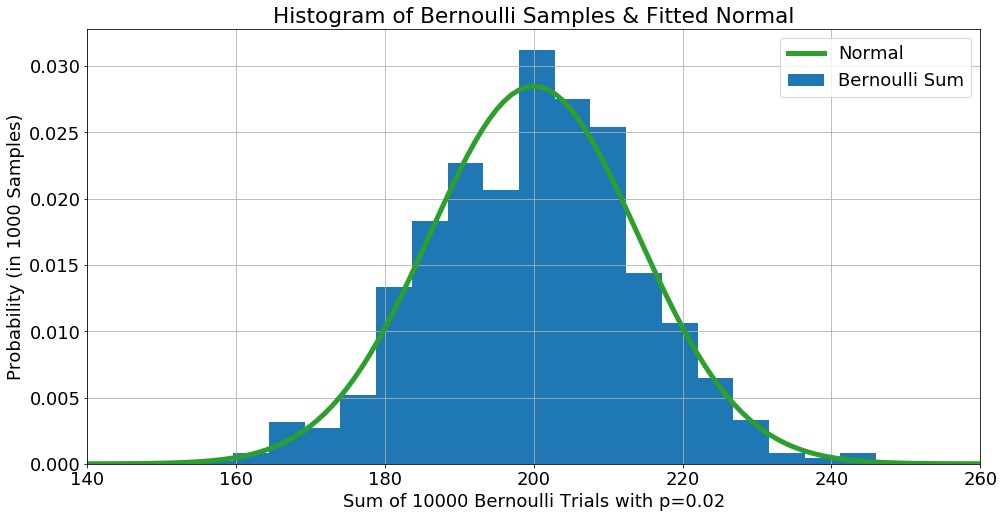

In [257]:
# The size of each sample
sample_size: int = 10000
# The number of replications (samples created)
sample_count: int = 1000
# The parameter p for the Bernoulli distribution
p: float = 0.02
q: float = 1.0 - p
# Bernoulli choices and their weights; use data type int8 to limit memory usage
bernoulli_choices = np.array([0.0, 1.0], dtype=np.int8)
bernoulli_weights = np.array([q, p])
# Draw the random samples - no fancy stuff or calls to binomial distribution libraries
# just independent trials with the given probability weights
np.random.seed(42)
bernoulli_samples = np.random.choice(a=bernoulli_choices, p=bernoulli_weights, \
                                     size=(sample_size, sample_count))

# Sum the columns to get 1000 realizations of a random variable X that is a sum of 10,000 Bernoulli trials
# One subtle point; np.int8 is sufficient to hold each Bernoulli trial, but NOT the sum over the trials,
# numpy is implicitly promoting X to data type int32.  The maximum really is 255, it's not a silent overflow!
X = np.sum(bernoulli_samples, axis=0)
# Normal parameters - we know these analytically, no need for fitting
mu = sample_size * p
sigma = np.sqrt(sample_size * p * q)
# Plot data for normal distribution to overlay
normal_x = np.arange(0, 1001, 1)
normal_y = norm.pdf(normal_x, loc=mu, scale = sigma)

fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Histogram of Bernoulli Samples & Fitted Normal')
ax.set_xlabel(f'Sum of {sample_size} Bernoulli Trials with p={p}')
ax.set_ylabel(f'Probability (in {sample_count} Samples)')
ax.set_xlim([140, 260])
ax.hist(x=X, bins=20, density=True, label='Bernoulli Sum')
ax.plot([],[])
ax.plot(normal_x, normal_y, label='Normal',linewidth=5)
ax.legend()
ax.grid()

** 3.4 ** There is an excellent fit! Wow, this Central Limit Theorem is legit.  The fit is even better when you use a larger m, e.g. 10000.

In [258]:
# 3.5. Formalize your answer to 3.3 and 3.4 by writing a program to compute the K-L divergence between the two 
# distributions (the sum of 10000 sampled Bernoullis and the appropriate Gaussian). 
# What is the value of the KL divergence.

def calc_kl_div(X, mu, sigma):
    """Compute the KL divergence between sample vector X and normal(mu, sigma)."""
    # Use formula for sampled KL on lecture 6, p. 34
    # Count distinct values of x and their frequencies quickly with numpy library routine
    xx, nn = np.unique(X, return_counts=True)
    # The emptirical probability pi is just ni over the count of X's
    count: int = np.sum(nn)
    pk = nn / count
    # Compute normal probability density at each point
    qk = norm.pdf(xx, loc=mu, scale=sigma)
    # Compute the log probability ratio; pi > 0 at all points
    log_ratio = log(pk / qk)
    # The KL formula is the mean of log(pi / qi)
    kl_div = np.sum(pk * log_ratio)
    # Compute the entropy of pk - this is a discrete sample, can use library routine    
    entropy_x = entropy(pk)
    # This is a normal distribution, use the analytical solution
    entropy_n = float(norm.entropy(mu, sigma))
    return (kl_div, entropy_x, entropy_n)

kl_div, entropy_x, entropy_n = calc_kl_div(X, mu, sigma)
print(f'The KL divergence between p and q is {kl_div:0.6f}')
print(f'The absolute entropies are {entropy_x:0.6f} for X and {entropy_n:0.6f} for the normal.')

The KL divergence between p and q is 0.051313
The absolute entropies are 4.017607 for X and 4.057996 for the normal.


**3.5** A KL diveregence of just 0.007 is very low; these two distributions are indeed very similar.

In [259]:
# Draw n Bernoulli samples using the Bernoulli parameter from 3.3 (p=0.02).
# Calculate the Kullback-Leibler divergence between the random variable defined by the sum of 
# Bernoullis samples and the appropriately fitted gaussian.
# For each sample size you should have 10 KL divergences. Construct a log scale (in both axes) plot of 
# the Kullback-Leibler divergence and the 3-σ envelope against the sample size. 
# What can you convergence of the distributions in question? What does this mean for the CLT?

def bernoulli_clt(ns: List[int], m: int, p: float):
    """
    For each of the specified ns, draw m samples from a random variable X
    which is a sum of n Bernoulli trials.
    ns: list of different ns to run the experiment on
     m: the the number of samples of X to draw (number of columns in matrix of Bernoulli trials summed up)
     p: the probability of drawing a 1 in the Bernoulli trial
    Returns:
    kls: a list of the KL divergences between the empirical distribution of X 
    and the normal distribution that fits it
    """
    # Number of sample sizes tried
    k: int = len(ns)
    # Array of KL divergences between Xi and its fitted normal
    kl_divs = np.zeros(k)
    # Array of entropy in the Xi and normals
    entropys_x = np.zeros(k)
    entropys_n = np.zeros(k)
    # Iterate over sample sizes
    for i, n in enumerate(ns):
        # Draw m samples from a binomial distribution representing the sum of n draws of a Bernoulli variable
        # This is a shortcut to simulating m*n draws from a Bernoulli variable.
        X = np.random.binomial(n, p, size=m)
        # Parameters for the normal corresponding to X
        mu = n * p
        sigma = np.sqrt(n * p * q)
        # Compute the KL divergence between this sample of X and the predicted normal
        kl_div, entropy_x, entropy_n = calc_kl_div(X, mu, sigma)
        # Save it to slot i of the kl_divs array
        kl_divs[i] = kl_div
        entropys_x[i] = entropy_x
        entropys_n[i] = entropy_n
    # Return the KL divergences for the various ns
    return (kl_divs, entropys_x, entropys_n)

def run_clt_trials(ns: List[int], m: int, p: float, reps: int):
    """Run reps repetitions of the experiment in bernoulli_clt"""
    # Numer of ns being tested
    k = len(ns)
    # Build a matrix with the KL divergences.
    # Each column is a set of draws for one n.
    kl_divs = np.zeros((reps, k))    
    entropys_x = np.zeros((reps, k))
    entropys_n = np.zeros((reps, k))
    # Repeate this experiment 10 times
    for i in range(reps):
        (kl_div, entropy_x, entropy_n) = bernoulli_clt(ns, m, p)
        kl_divs[i,:] = kl_div
        entropys_x[i,:] = entropy_x
        entropys_n[i,:] = entropy_n
    return (kl_divs, entropys_x, entropys_n)

As per Patrick's comment on Piazza, here is a brief word of justification about why I'm drawing $m$ times from a binomial distribution Bin$(n, p)$ rather than drawing $mn$ times from Bernoulli variables and summing up the columns.  The binomial distribution is the sampling distribution for summing up $n$ draws from a Bernoulli random variable with probability $p$ of 1, $1-p$ of 0.  This is a well known fact and was presented in the lecture 7 notes on page 40.  The quick intuition is that the order of the heads and tails doesn't matter, only the number of ways each total can be achieved. The probability of getting k heads and n-k tails in a specific order is $p^k (1-p)^{(n-k)}$, and there are $n$ choose $k$ ways to order the tosses with this total number of heads.  This is the definition of the binomial distribution.

Using the binomial distribution in place of drawing from raw Bernoulli distributions, then summing, is a big savings in memory usage and runtime and well worth doing.

/Users/adavydova/Desktop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log


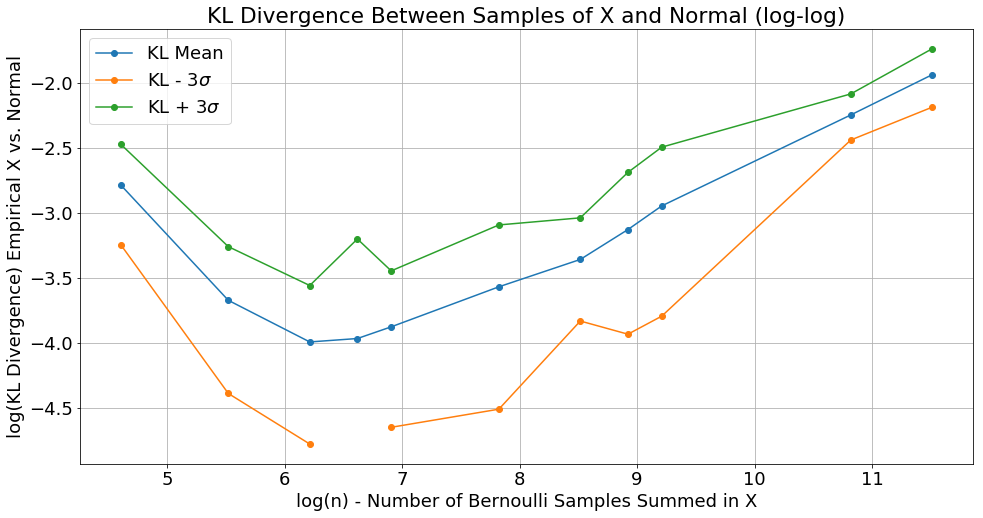

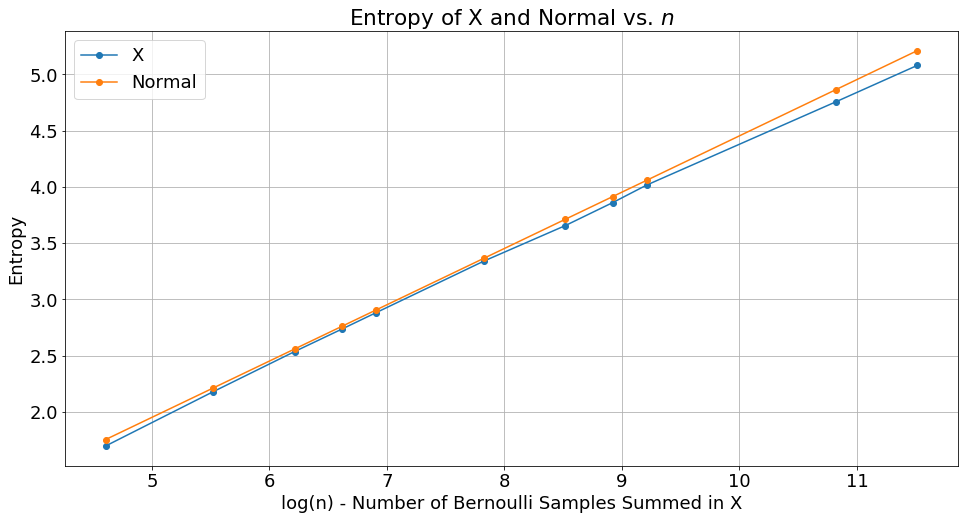

In [260]:
# Run the numerical experiment
# m is the sample_count (number of columns in the matrix); these are the draws from X 
m: int = 1000
# n is the sample_size (number of rows in the matrix); these will be summed up to make X
ns = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 50000, 100000]
# Number of times to run the experiment
reps: int = 10
# Result of the experiment in a matrix
kl_divs, entropys_x, entropys_n = run_clt_trials(ns, m, p, reps)
# Compute the mean and standard deviation of the KL divergence by n across the 10 repetitions
kl_mean = np.mean(kl_divs, axis=0)
kl_std = np.std(kl_divs, axis=0)
# Construct two envelopes at +/- 3 standard deviations around the mean
kl_lo = kl_mean - 3* kl_std
kl_hi = kl_mean + 3* kl_std

# Plot the log(KL divergence) vs. log(n)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('KL Divergence Between Samples of X and Normal (log-log)')
ax.set_xlabel('log(n) - Number of Bernoulli Samples Summed in X')
ax.set_ylabel('log(KL Divergence) Empirical X vs. Normal')
ax.plot(log(ns), log(kl_mean), marker='o', label='KL Mean')
ax.plot(log(ns), log(kl_lo), marker='o', label='KL - 3$\sigma$')
ax.plot(log(ns), log(kl_hi), marker='o', label='KL + 3$\sigma$')
ax.legend()
ax.grid()

# Compute the mean entropy of X and its normal distribution
entropy_x_mean = np.mean(entropys_x, axis=0)
entropy_n_mean = np.mean(entropys_n, axis=0)
# Plot the log(entropy_x) vs. log(entropy_n)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Entropy of X and Normal vs. $n$')
ax.set_xlabel('log(n) - Number of Bernoulli Samples Summed in X')
ax.set_ylabel('Entropy')
ax.plot(log(ns), entropy_x_mean, marker='o', label='X')
ax.plot(log(ns), entropy_n_mean, marker='o', label='Normal')
ax.legend()
ax.grid()

**3.6** This is an interesting result. The CLT tells us that the $X_i$ will converge to a normal distribution with an approximation error on the order of $1 / \sqrt{n}$.  And this is indeed the case - we can see that the samples are generally "pretty close" in the KL sense to the predicted normal distributions.  What this chart is making clear though is that the CLT does *not* guarantee us fast convergence to the normal distribution in the sense of the relative entropy getting lower as n increases.

As n increases, the entropy of *both* $X_i$ and its normal approximation are increasing.  This is intuitive when you think about it, because a the more times you toss a coin, the more information you need to know what happened.  I ran a second plot with the absolute entropy of both the normal distribution and the sampling distribution X.  This helped me to put the relative entropy results in context.  We can see that the total entropy of both $X_i$ and its normal approximation are growing in precisely linear fashion with a slope of $1/2$.  This matches the theoretical results.  As we learned in class, the entropy of a normal distribution is 
$1/2 \log(2\pi e \sigma^2) = \log(\sigma) + c$ and $\sigma^2 = n p q$ for a Bernoulli distribution.  So we expect to see an entropy of $1/2 \log(n) + c$ for the normal distribution and close to that for $X$.  The entropy of a binomial distribution is $1/2 \log(2\pi\,e\,n\,p\,q)$ i.e. the same as the result above.  See e.g. https://en.wikipedia.org/wiki/Binomial_distribution

So the takeaway here is that both $X_i$ and its approximating normal distribution move very closely together in entropy space as n increases over large regimes.  $X_i$ maintains a stable relative entropy to its normal distribution, but the gap does not appear to close asymptotically over this scale.

<div class="answer-separator">
------------------------
</div>

## Q4: Marvel at the DC Flash Light Speed experiment

Simon Newcomb did an experiment in 1882 to measure the speed of light. These are the times required for light to travel 7442 metres. These are recorded as deviations from 24,800 nanoseconds.

This data is in the following dataset $D$.

In [3]:
light_speed = np.array([28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25,
                        30, 23, 29, 31, 19, 24, 20, 36, 32, 36, 28, 25, 21, 28, 29,
                        37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27, 28,
                        27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25,
                        29, 27, 28, 29, 16, 23])

4.1. Plot a histogram of the data. Are there outliers in the data?  What data points might you consider to be outliers?

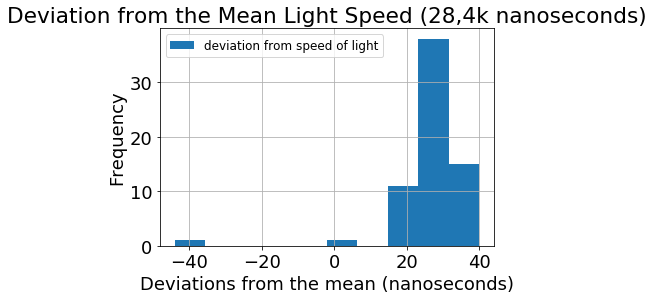

In [25]:
plt.hist(light_speed, label="deviation from speed of light")
plt.title("Deviation from the Mean Light Speed (28,4k nanoseconds)")
plt.xlabel("Deviations from the mean (nanoseconds)")
plt.ylabel("Frequency")
plt.legend(prop={'size': 12})
plt.grid()

A visual test of the dataset via the historgram above, suggests that we might have one or perhaps two outliers.  I am suprised to see a negative deviation because I interpreted the data as square root of variance which by definition cannot be negative. However, we are looking at deviation very simply as observed time - 28400 nano seconds, then negative values are certaintly possible. That being said, if we are taking this simple approach then the data implies that the vast majority of the observations was slower than the suggested mean of 28400 nano seconds. I am going to run an old fashioned oultier test on the data to see which points fall into the statistical definition of outliers. 

In [5]:
q75, q25 = np.percentile(light_speed, [75 ,25])
iqr = q75 - q25
mean=np.mean(light_speed)
high_threshhold=q75+1.5*iqr
low_threshhold=q25-1.5*iqr
outliers=[]
i=0
while i < len(light_speed):
    if    low_threshhold<light_speed[i] <high_threshhold:
        i=i+1
    else:
        outliers.append(light_speed[i])
        i=i+1
print("outliers:",outliers)       

outliers: [-44, -2]


Of course there is a less sporting way to think about this. We know from later scientific experiments that the speed of light  cc  is 3.00E8 to the first three significant figures. https://en.wikipedia.org/wiki/Speed_of_light The time to traverse 7442 meters should be 24,807 nanoseconds. It happens that the observed point at -2 is one of the closest ones to the "correct" answer of +7! However looking at this data I'm guessing there was a slight issue with Newcombe's setup and methodology that biased his results high (underestimating the speed of light.)

It appears that we have two outliers in the data that warrant further investigation.

4.2. We use a normal models with weakly informative priors to model this experiment. In particular assume uniform priors for both $\mu$ and $\sigma$:

$$\mu \sim Uniform(0, 60)$$

$$\sigma \sim Uniform(0.1, 50)$$

Write down an expression for the posterior (joint) pdf $p(\mu, \sigma \vert D)$.

**4.2** In general, the posterior joint probability of the paramters  given the observed data, 
$p(\mu, \theta | \mathbf{D})$, will be given by the prior probability $p(\mu, \theta | \mathbf{D})$ multiplied by the likelihood of the data given these parameter setttings.  In the caes of a Gaussian likelihood, we've seen in lecture 8, p. 33 that this takes the form:

$$ p(\mu, \sigma | {y_i}) \propto 
\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{1}{2\sigma^2}\sum(y_i-\mu)^2\right) p(\mu, \sigma)$$

This simplifies quite a bit here in the case of a uniform prior, where $p(\mu, \sigma)$ is a constant.  We can also get rid of the $2\pi$:

$$ p(\mu, \sigma | {y_i}) \propto \frac{1}{\sigma} \exp\left(-\frac{1}{2\sigma^2}\sum(y_i-\mu)^2\right)$$
The term $\sum(y_i-\mu)^2$ simplifies to $\mu^2 - 2B \mu + C$ where $B = \sum y_i$ and $C = \sum y_i^2$.  For this data set, $B=1730$ and $C=52852$.  We can define a function 
$$f(\mu, \sigma) = \frac{1}{\sigma} \exp(\frac{1}{2\sigma^2}(\mu^2-2B\mu+C)$$
This will be equal to the posterior up to a proportionality constant.  To get the actual posterior, we need to normalize it. Let $$N = \int_{\mu=0}^{60} \int_{\sigma=0.1}^{50} f(\mu, \sigma) d\sigma d\mu$$  Then
$$ p(\mu, \sigma | {y_i}) = f(\mu, \sigma) / N$$.

Overall, we have a truncated normal distribution since our prior probabilities are bounded by the ranges below (i.e p of values outside of the range is zero, taking our posterior to 0):
$$\mu \sim Uniform(0, 60)$$

$$\sigma \sim Uniform(0.1, 50)$$
<br>
p($\mu\sigma$)=p($\mu$)p($\sigma$)= $\Big\{\frac{1}{(b-a)*(d-c)}$ if $\mu$ and $\sigma$  $\in$ [0,60] and[0.1,50] and 0   if $\mu$ and $\sigma$  $\notin$ [0,60] and[0.1,50] 

**4.3.**    Set up a 500 point grid in both the $\sigma$ space and the $\mu$  space. Compute the normalized posterior on this grid and make a contour plot of it

In [6]:
muvalues = np.linspace(0, 60, 500)
sigmavalues = np.linspace(0.1, 50,500)
mu_mu, sigma_sigma = np.meshgrid(muvalues, sigmavalues)


In [7]:
def make_combined_grid(gridsize,data,sigma,mean):
    combined_grid=np.zeros((gridsize,gridsize))
    m=0
    while m < gridsize:
        n=0
        while n <gridsize:
            combined_grid[n,m] = (np.product(scipy.stats.norm.pdf(data, scale=sigma[n], loc=mean[m])))   
            n=n+1
        m=m+1
    Normalizer=np.sum(combined_grid)
    combined_grid=combined_grid/Normalizer
    return combined_grid


In [8]:
combined_grid=make_combined_grid(500,light_speed,sigmavalues,muvalues)

Text(0,0.5,'standard deviation')

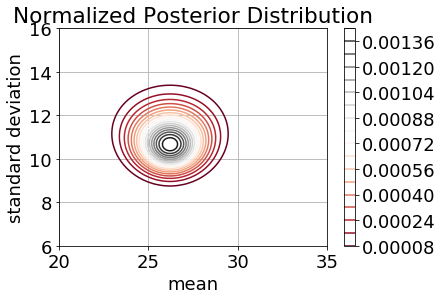

In [9]:
plt.contour(mu_mu, sigma_sigma, combined_grid,  20, cmap='RdGy')
plt.colorbar()
plt.ylim(6,16)
plt.xlim(20,35)
plt.grid()
plt.title("Normalized Posterior Distribution")
plt.xlabel("mean")
plt.ylabel("standard deviation")

4.4. Use this normalized posterior to sample from the grid, posterior samples of size 500000. That is the posterior should be of shape `(500000, 2)`. (Hint: one way to do it is to first flatten the meshgrid into a grid of shape (250000, 2). Flatten the posterior probabilities as well into a size 250000 vector. Then sample 500000 indices and use them to index the grid). Plot the $\mu$ and $\sigma$ marginal posteriors.

In [10]:
combinedpop=combined_grid.flatten()
mupop=mu_mu.flatten()
sigmapop=sigma_sigma.flatten()
n=np.random.choice(a=range(len(combinedpop)),p=combinedpop,size=500000, replace=True)

# can use uniform instead of our posterior

/Users/adavydova/Desktop/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


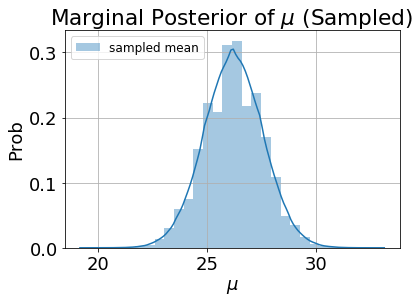

In [12]:
fig, ax = plt.subplots()
ax.set_title("Marginal Posterior of $\mu$ (Sampled)")
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Prob')
sns.distplot(mupop[n], ax=ax, bins=30, label="sampled mean")
ax.grid()
plt.legend(loc="upper left",prop={'size': 12})
plt.show()


/Users/adavydova/Desktop/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


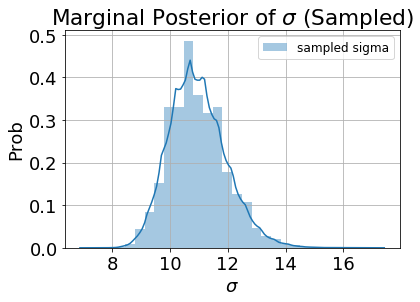

In [14]:
fig, ax = plt.subplots()
ax.set_title("Marginal Posterior of $\sigma$ (Sampled)")
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('Prob')
sns.distplot(sigmapop[n], ax=ax, bins=30, label="sampled sigma")
ax.grid()
plt.legend(prop={'size': 12})
plt.show()


4.5. Experiment with reducing the grid size down to 100x100. How do the marginal posteriors now look? What does this look tell us about the dimensional scaling of this grid-sampling-in-proportion-to-posterior method of obtaining samples?



In [15]:
muvalues1 = np.linspace(0, 60, 100)
sigmavalues1 = np.linspace(0.1, 50,100)
mu_mu1, sigma_sigma1 = np.meshgrid(muvalues1, sigmavalues1)


In [16]:
combined_grid1=make_combined_grid(100,light_speed,sigmavalues1,muvalues1)

Text(0,0.5,'standard deviation')

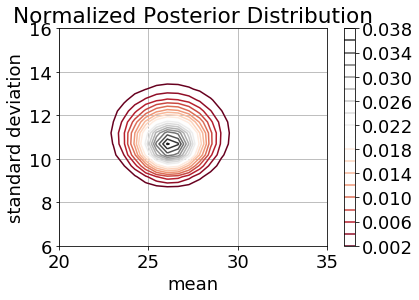

In [17]:
plt.contour(mu_mu1, sigma_sigma1, combined_grid1,  20, cmap='RdGy')
plt.colorbar()
plt.ylim(6,16)
plt.xlim(20,35)
plt.grid()
plt.title("Normalized Posterior Distribution")
plt.xlabel("mean")
plt.ylabel("standard deviation")

We notice right away that our Posterior Distribution is looking less smooth/more jagged, which I suspect doesn't bode well for our marginal distribution. Let's investigate further.

In [18]:
combinedpop1=combined_grid1.flatten()
mupop1=mu_mu1.flatten()
sigmapop1=sigma_sigma1.flatten()
n1=np.random.choice(a=range(len(combinedpop1)),p=combinedpop1,size=500000)


/Users/adavydova/Desktop/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


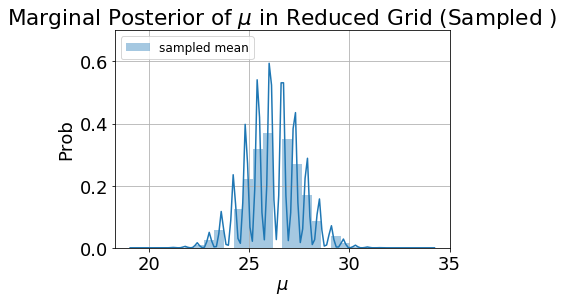

In [19]:
fig, ax = plt.subplots()
ax.set_title("Marginal Posterior of $\mu$ in Reduced Grid (Sampled )")
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Prob')
sns.distplot(mupop1[n1], ax=ax, bins=30, label="sampled mean")
ax.grid()
plt.legend(loc="upper left",prop={'size': 12} )
plt.ylim(0,0.7)
plt.show()


/Users/adavydova/Desktop/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


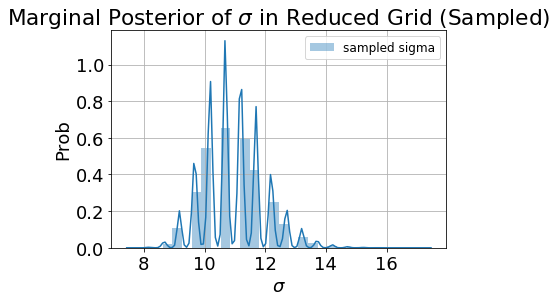

In [21]:
fig, ax = plt.subplots()
ax.set_title("Marginal Posterior of $\sigma$ in Reduced Grid (Sampled)")
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('Prob')
sns.distplot(sigmapop1[n1], ax=ax, bins=30, label="sampled sigma")
ax.grid()
plt.legend(prop={'size': 12})
plt.show()

Yes, just as we had expected, we have lost a lot of our normal marginal distribution by taking the grid size down to a 100x100. That speaks against the grid approach (especially given its computationally expensive as we increase grid size and dimensionality).  

In other words, shrinking the grid size from 500 to 100 completely crushed the shape of the marginal posterior for both  μ  and  σ . Both marginals now suffer from large discretization errors. The takeaway here is that grid based sampling scales very poorly in higher dimensions. It is forced to waste too much computation evaluating many points with tiny probabilities that are far from the action.

4.6. Now draw from the data sampling normal distribution to obtain the posterior-predictive distribution. You will have as many samples as the size of the posterior. Plot the posterior predictive distribution against the data, and write down your observations.

I am going to go back to using our more robust 500x500 grid for this exercise.

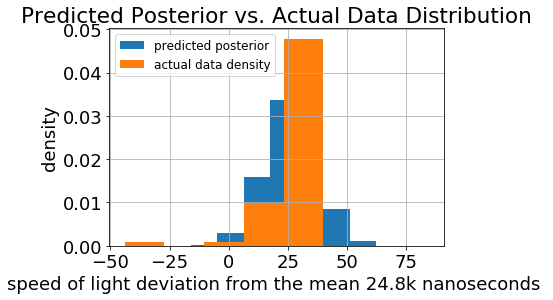

In [23]:

speed_pred=[]
n=np.random.choice(a=range(len(combinedpop)),p=(combinedpop),size=500000)
speed_pred=scipy.stats.norm.rvs(loc=mupop[n], scale=sigmapop[n])

plt.hist(speed_pred, density=True, label="predicted posterior")
plt.hist(light_speed, density=True, bins=5, label="actual data density")
plt.title("Predicted Posterior vs. Actual Data Distribution")
plt.xlabel("speed of light deviation from the mean 24.8k nanoseconds ")
plt.ylabel("density")
plt.legend(loc="upper left", prop={'size': 12})
plt.grid()

Here we note that our posterior predicted distribtion is smoother than the actual data, gradually capturing probabilities along a wide range of values and uncertainty but not all of it. It doesn't seem to capture one of our outliers, which is concerning since it might not be an outlier and this process has already been computationally expensive. But overall for the majority of observations our posterior predictive does a decent job wraping itself around the distribution. So if you have a data set with small spread this approach will do quite well. 



4.7. **Informally using a test-statistic**

We might wish to compute a test statistic from the posterior predictive. Say for example, we wish to talk about the minimum value of the posterior predictive.

The way to do this is to replicate the posterior predictive multiple times. We replicate the posterior-predictive (that is, do the sampling you did in 4.6) 66 times, which is the size of our dataset. In other words, we create as-many artificial datasets as there are samples in our posterior.

This is called a **replicative posterior predictive**.

Compute the replicative distribution of the minimum-value of the dataset and compare it to the actual value. What might you conclude about the quality of the specification of our model for the purposes of computing minimum values?

<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

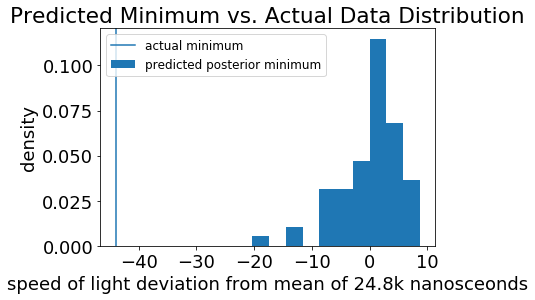

In [24]:
minimum=[]
for i in range(66):
    n=np.random.choice(a=range(len(combinedpop)),p=combinedpop,size=66)
    speed_pred=scipy.stats.norm.rvs(loc=mupop[n], scale=sigmapop[n])
    minimum.append(np.min(speed_pred))

plt.hist(minimum, density=True, label="predicted posterior minimum")
plt.axvline(x=np.min(light_speed), label="actual minimum")
plt.title("Predicted Minimum vs. Actual Data Distribution")
plt.xlabel("speed of light deviation from mean of 24.8k nanosceonds")
plt.ylabel("density")
plt.legend(loc="upper left",prop={'size': 12} )
plt.grid

The results are concerning as our replicative posterior predictive of the minimum values in each sample fails to capture the actual minimum of our sample. This is a great way to check the quality of our posterior predictive. In this case, it appears that the quality is not very high as we do not capture one influential outlier -44. This is concerning as this process tends to be computationally expensive as we increase grid size and dimensionality. Thus, other methods need to be exlored.